# Facial Expression Recognition in Real-time
Welcome to my Facial Expression Recognition project! In an age where non-verbal cues are as significant as the words we speak, understanding facial expressions becomes a crucial aspect of human-computer interaction. The primary goal of this project is to harness the power of machine learning and computer vision to recognize and classify human facial expressions in real-time.

## Overview:
Facial expressions are universal indicators of human emotions. Whether it's the evident joy in a smile or the subtle hints of surprise, our faces convey a multitude of emotions that transcend language barriers. In this project, we aim to delve deep into the world of computer vision to train a model that can accurately detect seven fundamental emotions: Happy, Sad, Angry, Surprised, Neutral, Disgusted, and Fearful.

### Key Features:
- __Data Exploration:__ Delve into the nuances of the FER2013 dataset, understanding its structure and the distribution of various facial expressions.
- __Model Development:__ Harness deep learning techniques, leveraging convolutional neural networks, and possibly exploring the benefits of transfer learning.
- __Real-time Analysis:__ Using OpenCV, capture video feed from a webcam and witness the model in action, identifying emotions on-the-fly.
- __Evaluation:__ Understand the model's strengths and weaknesses, using metrics like accuracy, precision, recall, and the F1-score.
- __Insights & Visualization:__ See which regions of a face our model focuses on to make its predictions, using techniques like Grad-CAM.

### Potential Applications:
The implications of a robust facial expression recognition system are vast:

- __Enhanced User Experience:__ Imagine video games or applications adapting in real-time to users' emotions, offering a tailored, responsive experience.
- __Mental Health Monitoring:__ Regular monitoring and analysis of a person's facial expressions could offer insights into their mental well-being.
- __Human-computer Interaction:__ Make machines more empathetic, understanding, and interactive, paving the way for truly personalized computing experiences.

## 

### Dependencies and data

In [36]:
# Import necessary libraries
import os
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [5]:
# Make sure kaggle is installed
# pip install kaggle

In [6]:
# Download and unzip the FER2013 dataset
kaggle.api.authenticate()
dataset_name = "deadskull7/fer2013"
kaggle.api.dataset_download_files(dataset_name, path='./', unzip=True)

print("FER2013 dataset downloaded and extracted!")

FER2013 dataset downloaded and extracted!


### 1. Load the dataset

In [16]:
# Load the dataset
data_path = "fer2013.csv"
df = pd.read_csv(data_path)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### 2. Examine the structure
The dataset has three columns:
- emotion: the emotion label.
- pixels: the pixel values for the images, space-separated.
- Usage: the purpose of this data (training, testing, validation).
Check the distribution of data across Usage:

In [17]:
print(df['Usage'].value_counts())

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64


### 3. Visualize some of the images

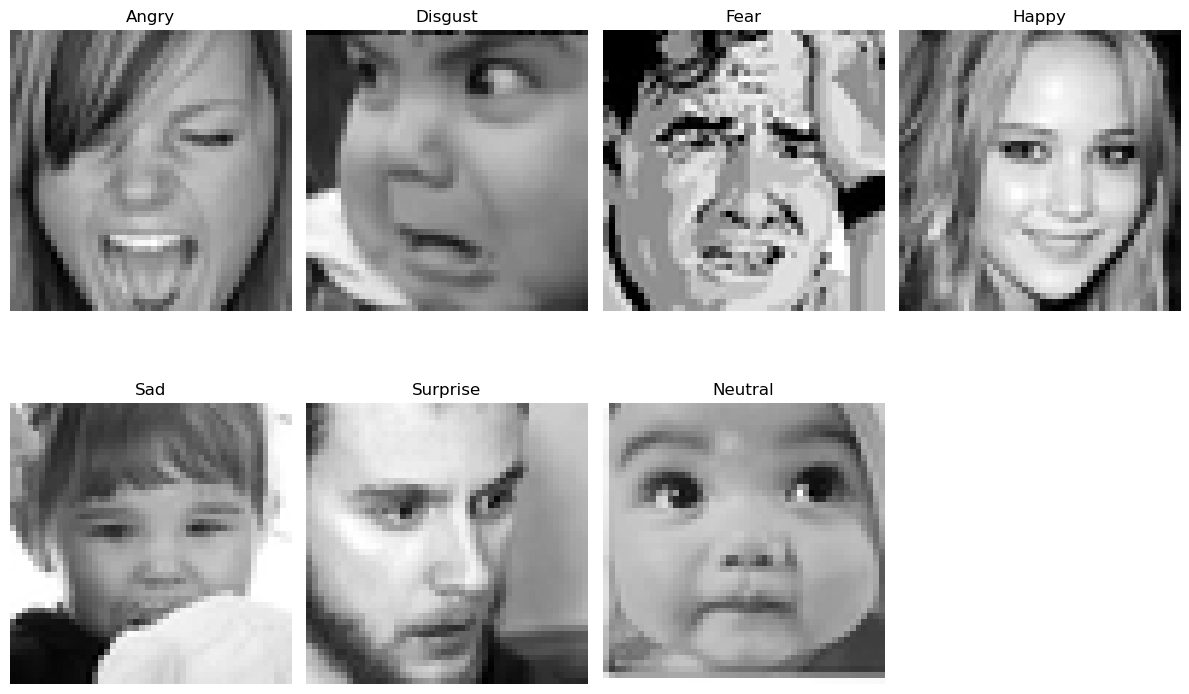

In [12]:
# Convert string pixels to numpy array
def string_to_image(pixel_string):
    pixels = np.array(pixel_string.split(' '), dtype=int)
    image = pixels.reshape(48, 48)
    return image

# Plot a random sample of images from each emotion
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(12, 8))
for i in range(7):
    plt.subplot(2, 4, i+1)
    random_sample = df[df['emotion'] == i].sample(1).iloc[0]
    image = string_to_image(random_sample['pixels'])
    plt.imshow(image, cmap='gray')
    plt.title(emotion_labels[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()


### 4. Examine the distribution of facial expressions

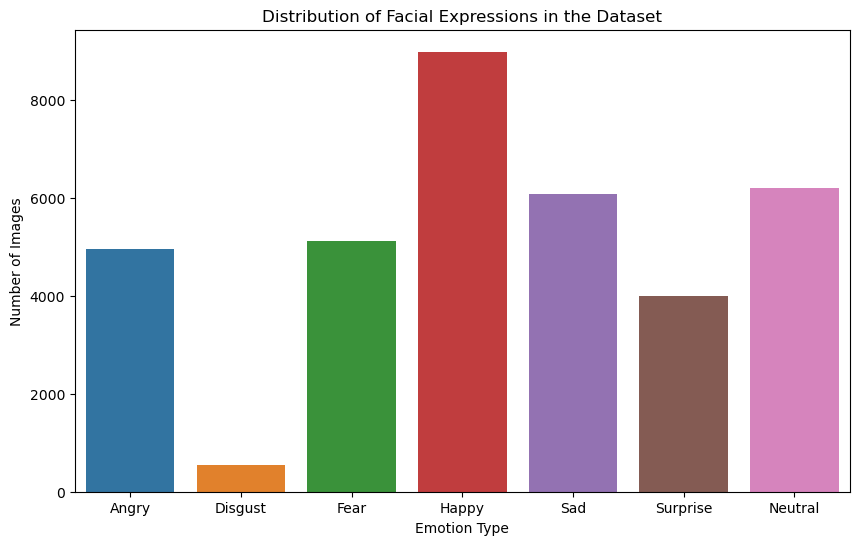

In [15]:
# Plot the distribution of the emotions
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df)
plt.title('Distribution of Facial Expressions in the Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Emotion Type')
plt.xticks(ticks=range(7), labels=emotion_labels)
plt.show()

## Datapreperations

### 1. Normalize the Images:
Neural networks tend to perform better when the input data is normalized. Given that these are grayscale images with pixel values ranging from 0 to 255, we can simply divide by 255 to scale the data to the range [0,1].

In [18]:
# Convert pixels to numpy arrays
df['pixels'] = df['pixels'].apply(lambda pixel_sequence: np.array(pixel_sequence.split(' '), dtype=float).reshape(48, 48) / 255.0)

### 2. Data Augmentation

Using data augmentation can be a good approach if you think the model might overfit. Augmentation artificially increases the size of the training dataset by applying transformations like rotation, zoom, shift, etc. Here's a basic setup using ImageDataGenerator from Keras:

In [22]:
data_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


### 3. Split the Dataset:
The FER2013 dataset provides predefined splits for training, validation, and testing. Let's utilize those:

In [24]:
# Splitting the dataset
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

X_train = np.stack(train_df['pixels'].to_numpy())
X_val = np.stack(val_df['pixels'].to_numpy())
X_test = np.stack(test_df['pixels'].to_numpy())

# We need to add an extra dimension since CNNs expect batches of multi-channel images
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_train = train_df['emotion'].to_numpy()
y_val = val_df['emotion'].to_numpy()
y_test = test_df['emotion'].to_numpy()

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 28709
Validation samples: 3589
Testing samples: 3589


## Model Building

### 1. Define the CNN Architecture
 Given the nature of the problem, a Convolutional Neural Network (CNN) is well-suited for this task. We can start with a relatively simple architecture and then fine-tune or expand as necessary.

In [27]:
model = Sequential([
    # First Convolutional Layer
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Second Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Third Convolutional Layer
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),

    # Flatten the results to feed into a dense layer
    Flatten(),
    
    # 256 neuron in the fully-connected layer
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # 7 output neurons for 7 classes with the softmax activation
    Dense(7, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 21, 21, 128)       5

This model uses a combination of convolutional layers followed by max-pooling. Dropout layers are added to prevent overfitting, and BatchNormalization helps in accelerating the training process.

### 2. Compile the model
To prepare the model for training, we need to compile it by specifying a loss function, an optimizer, and a metric to monitor during training.

In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


### 3. Train the Model
Now, we'll train the model. To leverage data augmentation, we'll utilize the ImageDataGenerator we defined earlier.

Once the model training starts, you'll observe the training and validation accuracy/loss for each epoch.

In [29]:
# Training parameters
epochs = 25
batch_size = 64

# Using data augmentation
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs)

Epoch 1/25
448/448 [==============================] - 199s 440ms/step - loss: 2.0001 - accuracy: 0.3061 - val_loss: 1.7673 - val_accuracy: 0.2510
Epoch 2/25
448/448 [==============================] - 178s 396ms/step - loss: 1.5127 - accuracy: 0.4215 - val_loss: 1.4739 - val_accuracy: 0.4355
Epoch 3/25
448/448 [==============================] - 178s 398ms/step - loss: 1.3879 - accuracy: 0.4680 - val_loss: 1.2654 - val_accuracy: 0.5238
Epoch 4/25
448/448 [==============================] - 174s 389ms/step - loss: 1.3227 - accuracy: 0.4909 - val_loss: 1.3233 - val_accuracy: 0.4731
Epoch 5/25
448/448 [==============================] - 172s 384ms/step - loss: 1.2898 - accuracy: 0.5086 - val_loss: 1.2589 - val_accuracy: 0.5180
Epoch 6/25
448/448 [==============================] - 167s 373ms/step - loss: 1.2763 - accuracy: 0.5128 - val_loss: 1.6086 - val_accuracy: 0.4561
Epoch 7/25
448/448 [==============================] - 166s 370ms/step - loss: 1.2462 - accuracy: 0.5245 - val_loss: 1.2163 -

After training, it's advisable to visualize the training history to check for overfitting and decide if further tuning is needed.

Remember, this is a foundational model. Depending on the performance, you might need to adjust the architecture, introduce regularization methods, or fine-tune hyperparameters.

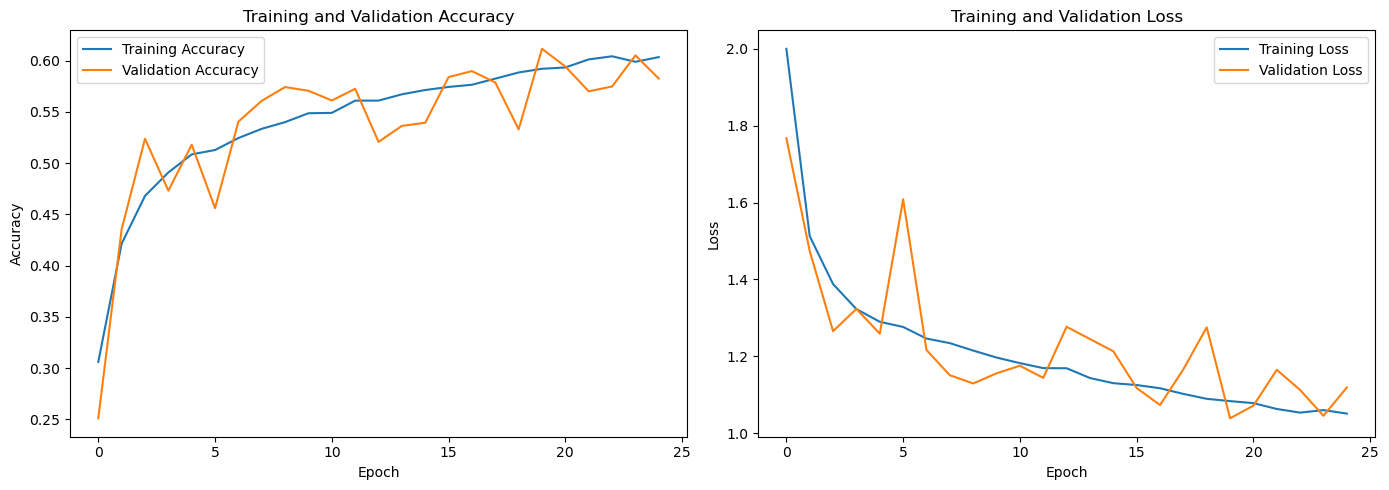

In [31]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### 4. Hyperparameter tuning

After the initial training of our facial expression recognition model, we obtained an accuracy of 60.35% on the training data and a validation accuracy of 58.26%. While these results are promising, there is room for improvement.

Hyperparameter tuning is a critical step in the process of building and refining machine learning models. The objective is to search for a combination of hyperparameters that will optimize the model's performance. This often involves making informed adjustments to various parameters such as the learning rate, batch size, architecture decisions (like the number of layers or neurons per layer), and regularization methods (e.g., dropout rate).

In [38]:
model = Sequential([
    
    # 1st convolution layer
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.5),

    # 2nd convolution layer
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.5),

    # 3rd convolution layer
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Flatten the results to feed into a dense layer
    Flatten(),

    # Fully connected neural networks
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),

    # 7 output neurons for 7 classes with the softmax activation
    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 conv2d_16 (Conv2D)          (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 conv2d_18 (Conv2D)          (None, 18, 18, 64)        36928     
                                                      